# Detect GPU

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load dataset

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

size=128
batch_size=16

# Load training images
train_ds = image_dataset_from_directory(
    '../chars',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(size, size),
    batch_size=batch_size,
    validation_split=0.3,
    seed=42,
    shuffle=True,
    subset="training",
)

# Load validation images
val_ds = image_dataset_from_directory(
    '../chars',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(size, size),
    batch_size=batch_size,
    validation_split=0.3,
    seed=42,
    shuffle=True,
    subset="validation",
)

Found 15376 files belonging to 62 classes.
Using 10764 files for training.
Found 15376 files belonging to 62 classes.
Using 4612 files for validation.


In [7]:
str(train_ds.class_names)

"['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '97', '98', '99']"

# Training

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

model = Sequential([
  # MobileNetV2
  MobileNetV2(input_shape=(128, 128, 3),
              include_top=False,
              weights='imagenet',
              pooling='avg'),
  
  # Dense layer
  Dense(64, activation='relu', input_dim=1000),
  Dense(32, activation='relu'),
  Dense(32, activation='relu'),

  # Output layer
  Dense(62, 'softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall')])

# Callbacks
early_stopping_callback = EarlyStopping(monitor='val_categorical_accuracy',
                         patience=5,
                         min_delta=0.001,
                         mode='max')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/tmp/checkpoint',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
log_dir = "../logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/200
673/673 [==============================] - 35s 45ms/step - loss: 0.8682 - categorical_accuracy: 0.7619 - precision: 0.8930 - recall: 0.6905 - val_loss: 31.7481 - val_categorical_accuracy: 0.0347 - val_precision: 0.0351 - val_recall: 0.0345
Epoch 2/200
673/673 [==============================] - 27s 39ms/step - loss: 0.1722 - categorical_accuracy: 0.9470 - precision: 0.9535 - recall: 0.9395 - val_loss: 17.9711 - val_categorical_accuracy: 0.0961 - val_precision: 0.0954 - val_recall: 0.0930
Epoch 3/200
673/673 [==============================] - 26s 39ms/step - loss: 0.1366 - categorical_accuracy: 0.9605 - precision: 0.9657 - recall: 0.9560 - val_loss: 15.0159 - val_categorical_accuracy: 0.1438 - val_precision: 0.1454 - val_recall: 0.1396
Epoch 4/200
673/673 [==============================] - 27s 40ms/step - loss: 0.1121 - categorical_accuracy: 0.9712 - precision: 0.9738 - recall: 0.9678 - val_loss: 10.1472 - val_categorical_accuracy: 0.3142 - val_precision: 0.3211 - val_recall:

In [13]:
# !tensorboard --logdir ../logs/fit

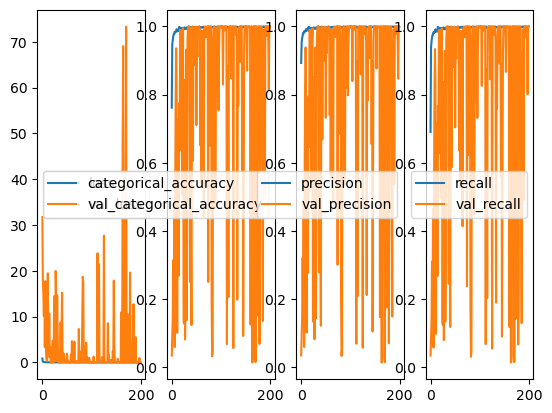

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

history_frame = pd.DataFrame(history.history)

fig, axes = plt.subplots(ncols=4)
history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot(ax=axes[1])
history_frame.loc[:, ['precision', 'val_precision']].plot(ax=axes[2])
history_frame.loc[:, ['recall', 'val_recall']].plot(ax=axes[3])
plt.show()

# Save model

In [11]:
model.save('../models/my_model2.h5')